# Inference
### Change `IMAGE_PATH` and run the notebook

In [1]:
import torch
import torch.nn.functional as F
import os
from torchvision import transforms
from torch import nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from dataset import DocDataset
from skimage import io
from skimage.color import rgb2gray
import numpy as np
import cv2
%matplotlib inline

In [2]:
class DocEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.act = nn.LeakyReLU(0.1)            
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)      
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up = nn.ConvTranspose2d(64,64,3,stride=2,padding=1, output_padding=1)
        self.conv5 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        self.out = torch.nn.Sigmoid()     
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.conv4(x)
        x = self.act(x)
        x = self.up(x)
        x = self.act(x)
        x = self.conv5(x)
        x = self.out(x)
        
        return x
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        op = self.forward(x)
        loss= F.mse_loss(op, y)
        self.log('train_loss', loss,on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        op = self.forward(x)
        loss= F.mse_loss(op, y)
        self.log('val_loss', loss,on_step=False, on_epoch=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer       
        
   


In [3]:
model = DocEncoder.load_from_checkpoint("best_model.ckpt")
model.eval()

DocEncoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Sigmoid()
)

In [4]:
def op_visualize(x,op):

    o_img = op.detach().cpu().numpy().squeeze(0)
    o_img = o_img.transpose(1,2,0)
    o_img = np.clip(o_img, 0, 1)
    x = x.detach().cpu().numpy().squeeze(0)
    x = x.transpose(1,2,0)
    io.imsave("test.jpg", o_img)

    f, axarr = plt.subplots(1,2,figsize=(10,20))
    axarr[0].imshow(x,cmap='gray')
    axarr[0].axis('off')
    axarr[1].imshow(o_img,cmap='gray')
    axarr[1].axis('off')
    
    plt.show()
    
    
    


In [7]:
IMAGE_PATH = "./images/i_img.jpeg"

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


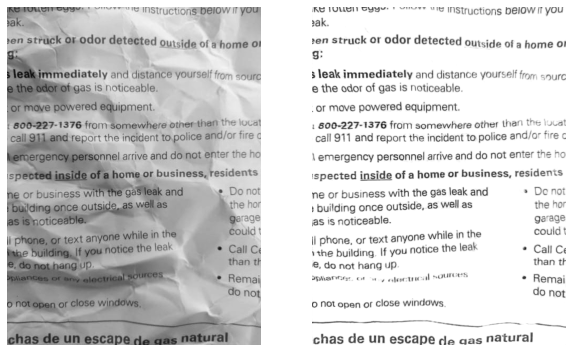

In [8]:
i_img = io.imread(IMAGE_PATH)
i_img = rgb2gray(i_img)
x = transforms.ToTensor()(i_img).unsqueeze(0)
x = x.to(dtype=torch.float32) 
op=model(x)
op_visualize(x,op)